# Assignment 6: Tree-Based Methods

## Introduction
In this coursework, you will classify houses into **high price** and **low price** categories based on their characteristics using tree-based methods.

### **Objectives**
- Use the **Ames Housing dataset**, which contains detailed property attributes.
- Train and compare **Decision Tree, Random Forest, and XGBoost** classifiers.
- Evaluate models using **confusion matrices and ROC-AUC**.
- Optimize hyperparameters with **GridSearchCV**.
- Interpret model decisions using **SHAP explainability**.

In [1]:
# Basic packages
import numpy as np
from functools import reduce
from io import BytesIO

# Data handling
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image
from tqdm import tqdm
%matplotlib inline

C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Dataset Description**
The dataset used is the **Ames Housing dataset**, which contains detailed information about residential houses in Ames, Iowa. Each row represents a house, and each column describes a characteristic of that house. Let's understand the **15 most important features** in the dataset:

1. **OverallQual**: The overall material and finish quality of the house.
2. **GrLivArea**: Above ground living area in square feet.
3. **GarageCars**: Number of car spaces in the garage.
4. **TotalBsmtSF**: Total basement area in square feet.
5. **1stFlrSF**: First-floor area in square feet.
6. **FullBath**: Number of full bathrooms.
7. **TotRmsAbvGrd**: Total number of rooms above ground level (excluding bathrooms).
8. **YearBuilt**: Year the house was constructed.
9. **Fireplaces**: Number of fireplaces in the house.
10. **GarageArea**: Size of the garage in square feet.
11. **LotArea**: Total lot size in square feet.
12. **KitchenQual**: Kitchen quality rating.
13. **BsmtFinSF1**: Finished basement square footage.
14. **Neighborhood**: The general location of the property within Ames.
15. **MSSubClass**: Identifies the type of dwelling.


- **Target Variable:** `SalePrice` (converted into a classification task: High vs. Low price).

## **Question 1: Data Preprocessing**
Before training your models, you need to clean and preprocess the dataset.

1. **Load the data `housing.csv` and display the first 5 rows.**

In [2]:
# Load Ames Housing Dataset
housing = pl.read_csv("housing.csv")

# Display the first few rows
housing.head(3)


Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
i64,i64,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
0,1,526301100,20,"""RL""",31770,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,5,1960,1960,"""Hip""","""CompShg""","""BrkFace""","""Plywood""","""TA""","""TA""","""CBlock""","""GasA""","""Fa""","""Y""",1656,0,0,1656,1,0,3,1,"""TA""",7,"""Typ""",2,"""P""",210,62,0,0,0,0,0,5,2010,"""WD ""","""Normal""",215000
1,2,526350040,20,"""RH""",11622,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",896,0,0,896,1,0,2,1,"""TA""",5,"""Typ""",0,"""Y""",140,0,0,0,120,0,0,6,2010,"""WD ""","""Normal""",105000
2,3,526351010,20,"""RL""",14267,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",1329,0,0,1329,1,1,3,1,"""Gd""",6,"""Typ""",0,"""Y""",393,36,0,0,0,0,12500,6,2010,"""WD ""","""Normal""",172000


1. **Convert the `SalePrice` column into a binary classification variable:**
   - If the house price is **above the median**, label it as **1 (High price)**.
   - If the house price is **below the median**, label it as **0 (Low price)**.
   
2. **Drop the original `SalePrice` column** after conversion.

3. **Encode categorical variables**:
   - Some columns contain text (e.g., `Neighborhood`, `House Style`).
   - Convert them into numerical values using **Label Encoding**.

4. **Standardize numerical features**:
   - Scale numerical values to improve model performance.
   - Use `StandardScaler()` from `sklearn.preprocessing`.

5. **Split the dataset into training and testing sets**:
   - Use an **80-20 split** (`train_test_split`).
   - Set `random_state=42` for reproducibility.
   - Use `stratify=y` to maintain class balance.

In [3]:
# Convert SalePrice into a binary target variable (1 for high price, 0 for low price)
housing = housing.with_columns(
    (pl.col("SalePrice") >= housing["SalePrice"].median()).cast(pl.Float64()).alias("SalePrice2")
)

# Drop original SalePrice column
housing = housing.drop("SalePrice")

# Encode categorical variables
categorical_columns = [col for col in housing.columns if housing[col].dtype == pl.Utf8]
le = LabelEncoder()
encoded_columns = {col: le.fit_transform(housing[col].to_list()) for col in categorical_columns}
housing = housing.with_columns([pl.Series(col, encoded_columns[col]) for col in categorical_columns])

# Define Features (X) and Target (y)
X = housing.drop("SalePrice2")
X_columns = X.columns
Y = housing["SalePrice2"] 

# Convert X to NumPy before train-test split
X = X.to_numpy()

# Perform Train-Test Split (with stratification)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                Y,
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=Y
                                                )

# Standardize Numerical Features
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

## **Question 2: Model Training and Evaluation**
You will train three classification models:
- **Decision Tree** (`random_state = 42`)
- **Random Forest** (`random_state = 42`)

1. **Train the models on the training set. Make sure you use the optimal number of trees for the Random Forest.**.
2. **Evaluate models using the following metrics**:
   - **Confusion Matrix**: Displays True Positives, True Negatives, False Positives, and False Negatives.
   - **ROC-AUC Score**: Measures the model’s ability to distinguish between classes.
   - **ROC Curve**: Plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

3. **Plot the ROC curves for all models in one figure**.

In [4]:
# Define hyperparameter grids
plt.figure(figsize=(10, 15))
depths = {"classifier__max_depth":np.arange(1,12)}
param_grid = {"classifier__n_estimators": np.arange(30,100)}

# Define base models

            # Decision tree base model
reg = DecisionTreeClassifier(max_depth=12)
clf = Pipeline(steps=[("classifier",reg)])
clf.fit(Xtrain, ytrain)

            # Random forest base model
placement_rf = RandomForestClassifier(n_estimators=30, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='sqrt', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=42, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced', # Balance classes.
                                    )
rff = Pipeline(steps=[("classifier",placement_rf)])
rff.fit(Xtrain, ytrain)
# Hyperparameter tuning and model evaluation
    # Perform Grid Search to find the best hyperparameters
grid_search_dtree = GridSearchCV(clf, depths, cv=5)
grid_search_rf = GridSearchCV(rff, param_grid, cv=5)
    # Get the best model
grid_search_dtree.fit(Xtrain, ytrain) # decision tree
grid_search_rf.fit(Xtrain, ytrain) # random forest
    


    


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               min_impurity_decrease=0.0001,
                                                               min_samples_leaf=0.001,
                                                               n_estimators=30,
                                                               n_jobs=-1,
                                                               oob_score=True,
                                                               random_state=42))]),
             param_grid={'classifier__n_estimators': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
       98, 99])})

<Figure size 1000x1500 with 0 Axes>

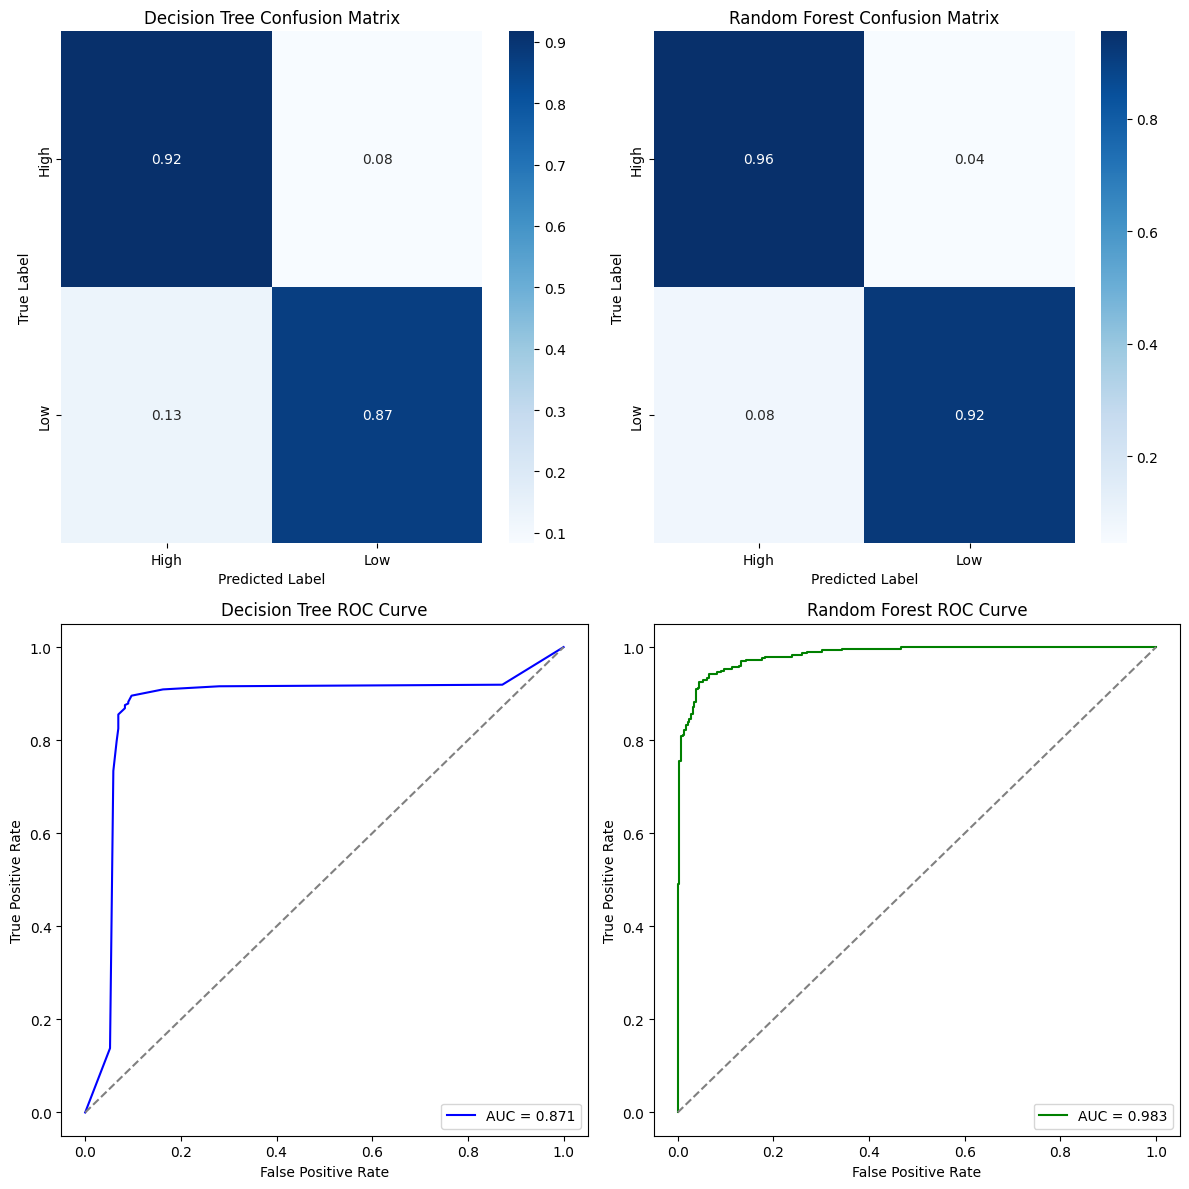

In [5]:
# Predictions
dt_pred_class_test = grid_search_dtree.predict(Xtest)
dt_probs_test = grid_search_dtree.predict_proba(Xtest)
rf_pred_class_test = grid_search_rf.predict(Xtest)
rf_probs_test = grid_search_rf.predict_proba(Xtest)
    # Evaluation metrics
   # Decision tree
confusion_matrix_dt = confusion_matrix(y_true = ytest.to_numpy(), y_pred = dt_pred_class_test)
confusion_matrix_dt = confusion_matrix_dt.astype('float') / confusion_matrix_dt.sum(axis=1)[:, np.newaxis]
df_cm_dt = pd.DataFrame(
        confusion_matrix_dt, index=['High', 'Low'],
        columns=['High', 'Low'])

fpr, tpr, thresholds = roc_curve(y_true = ytest.to_numpy(),
                                 y_score = dt_probs_test[:,1],
                                 pos_label=1)
auc_dt = np.round(roc_auc_score(y_true = ytest.to_numpy(), y_score = dt_probs_test[:,1]), decimals = 3)

    # Random forest
confusion_matrix_rf = confusion_matrix(y_true = ytest.to_numpy(), y_pred = rf_pred_class_test)
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]
df_cm_rf = pd.DataFrame(
        confusion_matrix_rf, index=['High', 'Low'],
        columns=['High', 'Low'],)
fpr2, tpr2, thresholds2 = roc_curve(y_true = ytest.to_numpy(),
                                 y_score = rf_probs_test[:,1],
                                 pos_label=1)
auc_rf = np.round(roc_auc_score(y_true = ytest.to_numpy(), y_score = rf_probs_test[:,1]), decimals = 3)
    

# Plot ROC Curves
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Decision Tree Confusion Matrix
sns.heatmap(df_cm_dt, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Decision Tree Confusion Matrix')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Plot 2: Random Forest Confusion Matrix
sns.heatmap(df_cm_rf, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Random Forest Confusion Matrix')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Plot 3: Decision Tree ROC Curve
axes[1, 0].plot(fpr, tpr, label=f'AUC = {auc_dt}', color='blue')
axes[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
axes[1, 0].set_title('Decision Tree ROC Curve')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend(loc=4)

# Plot 4: Random Forest ROC Curve
axes[1, 1].plot(fpr2, tpr2, label=f'AUC = {auc_rf}', color='green')
axes[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
axes[1, 1].set_title('Random Forest ROC Curve')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend(loc=4)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## **Question 3: Hyperparameter Tuning**
Hyperparameter tuning helps improve model performance by finding the best parameters.

1. **Tune XGBoost using GridSearchCV with five folds**:
   - Search for the best `n_estimators`, `max_depth`, and `learning_rate:`.

2. **Show the best number for each hyperparameter**:

3. **Calculate a ROC curve and its corresponding AUC. Compare these results with the previous models.**

In [6]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {"classifier__n_estimators": np.arange(90,150), "classifier__max_depth": np.arange(1,15), "classifier__learning_rate": np.arange(0,0.2,0.04)}
positive_weight = ytrain.to_pandas().value_counts().iloc[0] / ytrain.to_pandas().value_counts().iloc[1]
print(f"The balanced weight for the loss function is {positive_weight:.3f}")

# Initialize the XGBoost classifier
XGB_Placement = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=0,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=positive_weight,  # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=42        # Seed
                            )

xgb = Pipeline(steps=[("classifier",XGB_Placement)])
xgb.fit(Xtrain, ytrain)

# Perform Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1, refit=True,verbose=0)
    # Get the best model
grid_search_xgb.fit(Xtrain, ytrain) # XGB Boosting

The balanced weight for the loss function is 1.029


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=0.001,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints...
                         'classifier__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'classifier__n_estimators': array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149])},
             scoring='roc_auc')

{'classifier__learning_rate': np.float64(0.08), 'classifier__max_depth': np.int64(12), 'classifier__n_estimators': np.int64(110)}


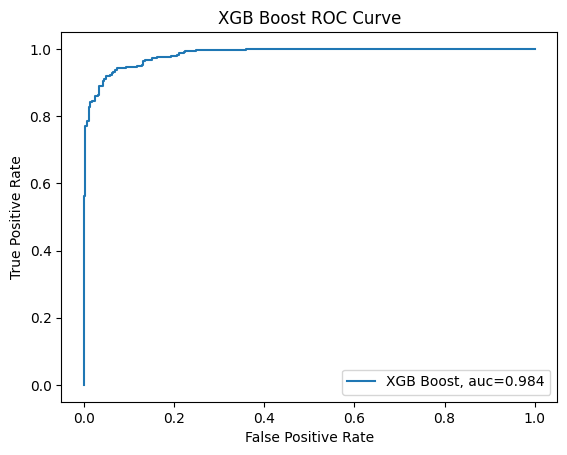

In [7]:
# Display the best hyperparameters
print(grid_search_xgb.best_params_)
# learning rate = 0.08, max depth = 12, n estimators = 110

# Calculate AUC and plot ROC curve.
xgb_pred_class_test = grid_search_xgb.predict(Xtest)
xgb_probs_test = grid_search_xgb.predict_proba(Xtest)[:,1]

fpr3, tpr3, thresholds3 = roc_curve(ytest, xgb_probs_test, pos_label=1)
auc_xgb = np.round(roc_auc_score(y_true = ytest.to_numpy(), y_score = xgb_probs_test), decimals = 3)

plt.plot(fpr3,tpr3,label=f"XGB Boost, auc={auc_xgb:.3f}")
plt.legend(loc=4)
plt.title("XGB Boost ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Written answer:** Compared to the random forest and decision tree models, the XGB boost has a higher AUC, which can be interpreted as the XGB boost being a better fit to predicting the response than the other two methods.

## **Question 4: Model Explainability with SHAP**
Machine learning models can be difficult to interpret. SHAP helps us understand which features are most important in predictions.

1. **Apply SHAP to the best-tuned XGBoost model**.
2. **Generate a SHAP Summary Plot**:
   - Displays the most important features and their impact.
3. **Interpret the results**:
   - Explain the plot for the top three features?
   - Does the result make sense?

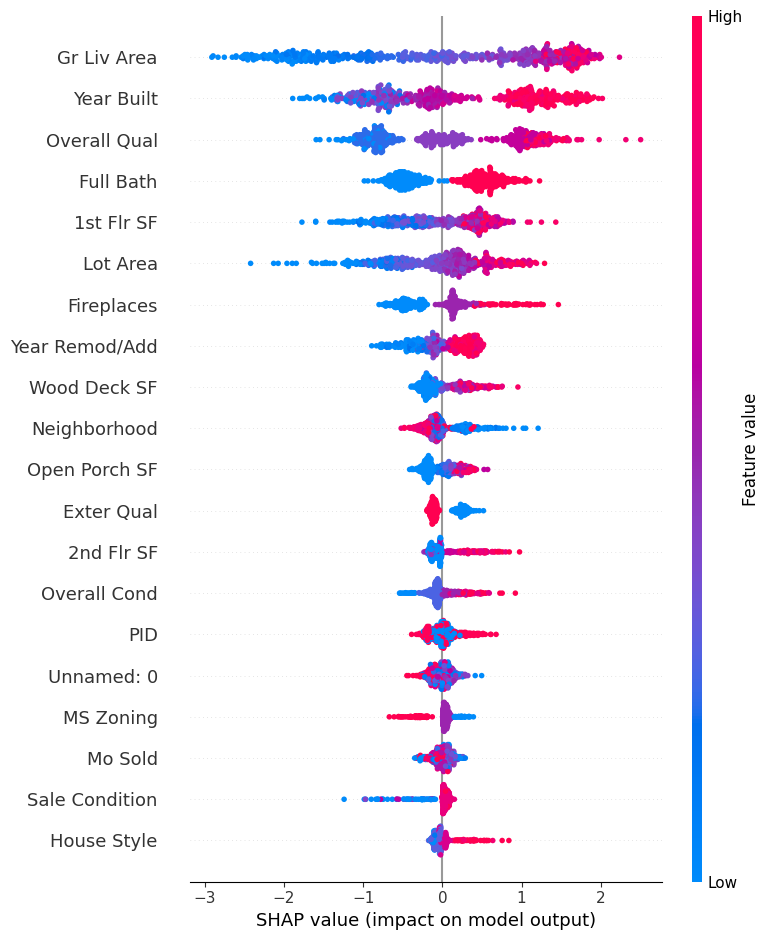

In [8]:
# Use the best-tuned XGBoost model from GridSearch
best_xgb_model = XGBClassifier(max_depth=12,                 # Depth of each tree
                            learning_rate=0.08,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=110,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=0,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            scale_pos_weight=positive_weight,  # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=42        # Seed
                            )
xgbbest = Pipeline(steps=[("classifier", best_xgb_model)])
xgbbest.fit(Xtrain, ytrain)

# Apply SHAP to the best XGBoost model
explainer = shap.TreeExplainer(xgbbest.named_steps["classifier"], data=shap.sample(Xtest,1000), feature_names=X_columns)
shap_values = explainer.shap_values(Xtest, check_additivity=False)

# Generate SHAP Summary Plot
shap.summary_plot(shap_values,
                  Xtest,
                  show=True, feature_names=X_columns) 

**Written Answer:** The most important features according to the shap summary are **GrLivArea**: Above ground living area in square feet, **YearBuilt**: Year the house was constructed, and **OverallQual**: The overall material and finish quality of the house. 

- The low values of GrLivArea are very helpful to predict the low price housing. The high values of GrLivArea is fairly helpful to predict the high price housing. 
- The high values of YearBuilt are extremely helpful to predict the high price housing, while the low values are not very helpful to predict low price housing.
- Overall quality has high values that are mostly helpful to predict high price housing with a few perceived outliers that are extremely good predictors. For low values, it is about hte same as for YearBuilt


If we want to predict if the housing price is high or low, these do make practical sense. Above ground living area is valued because of factors like sunlight and easy accessibility. Year built ensures that most houses are built to modern standards, so no leaks or parasites (hopefully). Lastly, overall quality is valued because it is the impression of the house on the potential buyers. People want a comfortable and premium house for their budgets. 